In [2]:
from itertools import groupby
import numpy as np
import pydicom
import sys
from pathlib import Path
from tqdm import tqdm
from pyvista import RectilinearGrid, StructuredGrid, UniformGrid, read as pvread, PolyData
import matplotlib.pyplot as pl
#from scipy.spatial import KDTree
from read_4dflow_dicom import distance_map

In [3]:

### Read dicom-files
path = Path().home()/'Downloads/anonym/001'
#dcm = [pydicom.dcmread(f) for f in sorted(path.rglob('*.dcm'), key=lambda f: int(f.stem.split('_')[-1]))]
print('  Reading dicom-files...')
#dcm = sorted([(pydicom.dcmread(f),f) for f in tqdm(list(path.rglob('*.dcm')))], key=keyfunc)
dcm = [(pydicom.dcmread(f),f) for f in tqdm(list(path.rglob('*.dcm')))]


  Reading dicom-files...


100%|██████████| 3840/3840 [00:05<00:00, 656.59it/s]


In [5]:
print(dcm[0])

(Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.2.18.42383.20220602150346617572462
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'MIRCTN16NOV2000'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'P', 'RETRO', 'DIS2D']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Instance Creation Time              TM: ''
(0008, 0016) SOP Class UID                       UI: ''
(0008, 0018) SOP Instance UID       

In [6]:
### Group dicom on series number
number = lambda x: x[0].SeriesNumber
location = lambda x: -x[0].SliceLocation
series = [list(g) for k,g in groupby(sorted(dcm, key=number), key=number)]
### Sort series on file number
series = [sorted(s, key=lambda x: x[0].InstanceNumber) for s in series]
series = [sorted(s, key=location) for s in series]
### slices[series][slice][time][0=dcm, 1=file]
slices = [[list(g) for k,g in groupby(s, key=location)] for s in series]


In [36]:
S = np.array(slices).transpose(0,2,1,3)[:,:,:,0]
S0 = S[0,0,0]
print(S.shape)
nx, ny, nz = S0.Rows, S0.Columns, S.shape[-1]

### Extract pixel_array
pixels = np.array([s.pixel_array for s in S.flatten()], dtype=np.double).reshape(S.shape+(nx, ny)).transpose(1,0,3,4,2)
#pl.figure(), pl.pcolormesh(pixels[7,0,:,:,20]), pl.colorbar()
print(pixels.shape)
### Adjust velocity
venc = np.array((200, 200, 200))
level = 2**S0.HighBit-1
#pixels[:,:3,...] = (pixels[:,:3,...]-level)*venc[None, :, None, None, None] / level
pixels[:, :3, ...] = (pixels[:, :3, ...]-level) * venc[None, :, None, None, None] / level
#pl.figure(), pl.pcolormesh(pixels[7,0,:,:,20]), pl.colorbar()


(4, 20, 48)
(20, 4, 160, 120, 48)


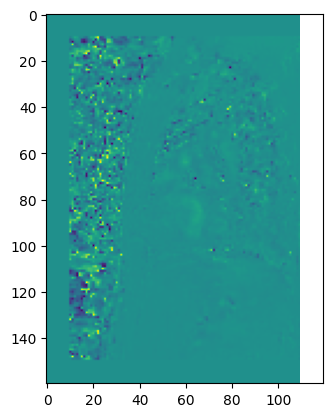

In [40]:
pixels[:,:,:10,:,:] = 0
pixels[:,:,:,:10,:] = 0
pixels[:,:,-10:,:,:] = 0
pixels[:,:,:,-10:,:] = np.NAN
#import matplotlib.pyplot as pl
#pl.figure()
pl.imshow(pixels[10,0,:,:,11])

In [8]:
time = np.array([s.TriggerTime for s in S.flatten()]).reshape(S.shape).transpose(1,0,2)
time[2,0,0]

85.326019287109

In [19]:
X, Y = np.split(np.array(S0.ImageOrientationPatient), 2)
Z = np.cross(X, Y)
#IPP = np.array([s.ImagePositionPatient for s in S.flatten()]).reshape(S.shape + (3,))
IPP = np.array([s.ImagePositionPatient for s in S[0,0,:2]])
#print(IPP)
(dx, dy), dz = S0.PixelSpacing, np.abs(np.dot(Z, IPP[1]-IPP[0]))
#print(dx, dy, dz)
#M = np.zeros((4,4))
M = np.column_stack((X, Y, Z, IPP[0]))
#M = np.column_stack((X, Y, np.zeros(3), IPP[0]))
#M = np.column_stack((np.identity(3), IPP[0]))
M = np.vstack((M,[0,0,0,1]))
M
#D[0,0,1,1].name
#np.dot(Z,IPP[2]-IPP[1])
#dist = np.dot(IPP,Z)


array([[  0.33873796,   0.        ,  -0.94088076,  22.26971302],
       [  0.94088076,   0.        ,   0.33873796, -98.85016691],
       [  0.        ,  -1.        ,   0.        , 178.00695482],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [20]:
pixels.shape

(20, 4, 921600)

In [15]:
### Grid spacing and dimensions
(dx, dy), dz = S0.PixelSpacing, np.abs(np.dot(Z, IPP[1]-IPP[0]))
nx, ny, nz = S0.Rows, S0.Columns, S.shape[-1]

### Create grid
grid = UniformGrid()
grid.origin = (0, 0, 0)
### Note the interchange between x- and y-axis!!!
grid.dimensions = np.array([ny, nx, nz]) + 1
grid.spacing = np.array((dy, dx, dz))
pixels = pixels.transpose(0,1,3,2,4).reshape(pixels.shape[:2] + (-1,), order='F')
### Rotate grid
grid = grid.transform(M, inplace=False)
grid_cells = grid.cell_centers().points.astype(np.double)
#vars = ('vx', 'vy', 'vz', 'magnitude')


In [17]:
grid.dimensions

(121, 161, 49)

/opt/local/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


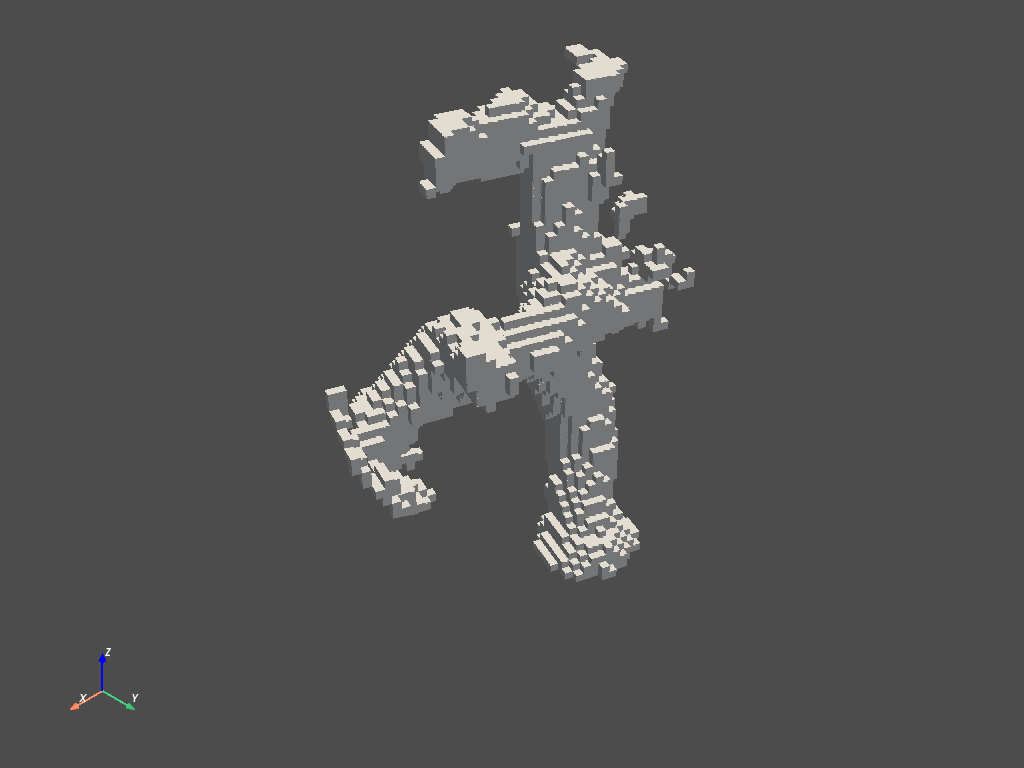

In [11]:
from operator import attrgetter
### Use STL-file to remove data outside the blood vessels
#STL = '4DFlowBloodpoolEdit1807_1_Edit1807_mesh.stl'
STL = '001_fontan_closed.stl'
surface = pvread(STL).extract_surface()
dist_map = distance_map(surface, grid)
grid['distance'] = dist_map
grid = grid.threshold(value=(0,10), scalars='distance')
#grid.plot()
clusters = grid.connectivity().split_bodies()
main = sorted(clusters, key=attrgetter('n_cells'))[-1]
main.plot()
# min, max = np.hsplit(np.array(mesh.bounds).reshape((3,2)), 2)
# mesh_cells = mesh.cell_centers().points.astype(np.double)
# mesh_normals = mesh.cell_normals
# dist, idx = KDTree(mesh_cells).query(grid_cells, k=1, workers=2)
# norm_dot_vec = mesh_normals[idx] * (mesh_cells[idx]-grid_cells)
# outside = np.sum(norm_dot_vec, axis=1) < 0
# pixels[..., outside] = 0


In [12]:
bounds = np.array(mesh.bounds).reshape((3,2))
### Interchange x- and y-axis
bounds[[1,0]] = bounds[[0,1]]
min, max = bounds.T
#off_limits = np.any(grid_cells < min, axis=1) * np.any(grid_cells > max, axis=1)
off_limits = np.any((grid_cells < min) + (grid_cells > max), axis=1)
pixels[..., off_limits] = 0

NameError: name 'mesh' is not defined

In [ ]:
off = (grid_cells < min)+(grid_cells > max)
off[:3]
np.any(off, axis=1)[:3]

pyvista_ndarray([ True,  True,  True])

In [ ]:
np.any(grid_cells < min, axis=1)[:3]

pyvista_ndarray([ True,  True,  True])

In [13]:

### Write data as vtk cell-data
### Loop over times
for i, series in tqdm(list(enumerate(pixels))):
    vtk = grid.copy()
    # ### Loop over series
    # for var, data in zip(vars, series):
    #     vtk.cell_data[var] 
    vtk.cell_data['magnitude'] = series[3].transpose(1,0,2).flatten(order='F')
    vtk.cell_data['velocity'] = np.transpose(np.vstack([s.transpose(1,0,2).flatten(order='F') for s in series[:3]]))
    vtk.save(f'test_{i:02d}.vtk')

  0%|          | 0/20 [00:00<?, ?it/s]


ValueError: axes don't match array

: 

In [ ]:
np.column_stack((np.identity(3), IPP[0]))

array([[  1.        ,   0.        ,   0.        ,  22.26971302],
       [  0.        ,   1.        ,   0.        , -98.85016691],
       [  0.        ,   0.        ,   1.        , 178.00695482]])

In [ ]:
S0.HighBit

11